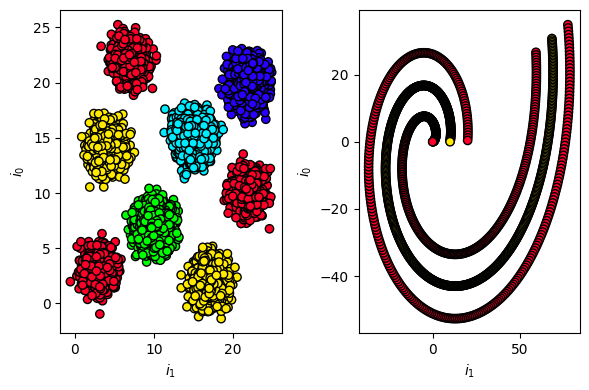

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from src.common.train_data import normal2DCluster, logSpiral2D

cov = np.diag((1,1))

classes = [(0, (3,3), cov, 1000),
           (1, (14,4), cov, 1500),
           (2, (7,10), cov, 3000),
           (3, (15,15), cov, 3000),
           (1, (2,17),cov, 1500),
           (0, (10,22), cov, 1000),
           (0, (22,7), cov, 1000),
           (4, (20,22), cov, 3000)]
n_classes = 5
train_data, train_labels = normal2DCluster(classes)
train_data2, train_labels2 = logSpiral2D(10, 0.3, 600, 1)
n_classes2 = 2

train_min_y = train_data[:,0].min()
train_max_y = train_data[:,0].max()
train_min_x = train_data[:,1].min()
train_max_x = train_data[:,1].max()
train2_min_y = train_data2[:,0].min()
train2_max_y = train_data2[:,0].max()
train2_min_x = train_data2[:,1].min()
train2_max_x = train_data2[:,1].max()

cmap = plt.get_cmap('gist_rainbow')
def colorizeLabel(l):
  return cmap(l/n_classes)

fig, ax = plt.subplots(1,2)
fig.set_tight_layout(True)
fig.set_dpi(100)
ax[0].scatter(train_data[:,1], train_data[:,0], c=colorizeLabel(train_labels), edgecolor='black')
_ = ax[0].set_ylabel("$i_0$")
_ = ax[0].set_xlabel("$i_1$")
ax[1].scatter(train_data2[:,1], train_data2[:,0], c=colorizeLabel(train_labels2), edgecolor='black')
_ = ax[1].set_ylabel("$i_0$")
_ = ax[1].set_xlabel("$i_1$")

/home/jonas/Workspaces/python/spass_mit_python/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epochs:  21%|██▏       | 171/800 [02:44<13:38,  1.30s/epoch, total_loss=722.34]

KeyboardInterrupt: 

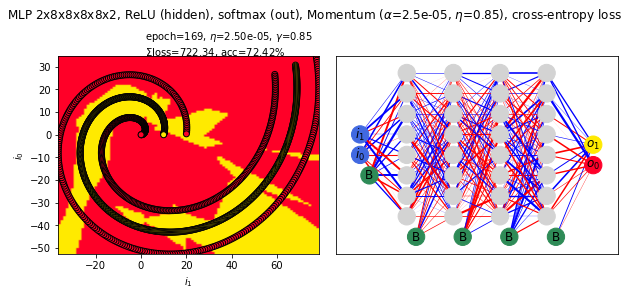

In [4]:
from src.neuronal_network.mlp import MLP
from src.neuronal_network.loss import MSE, CrossEntropy
from src.neuronal_network.activation import Sigmoid, ReLU, SoftMax
from src.neuronal_network.optimizer import Momentum
from src.common.plot import sample2DClassifier, plotMultiWeightLayer
from src.common.vectorize import one_hot
from matplotlib.animation import FuncAnimation
from datetime import datetime
from IPython.display import Video
import tqdm

batch_size = 50
epochs = 800
learning_rate = 25e-6
momentum = 0.85
duration_ms = max(epochs*80, 3000)

optimizer = lambda: Momentum(learning_rate, momentum)
mlp = MLP(2, [8,8,8,8], n_classes2, hidden_act=ReLU, output_act=SoftMax, optimizer=optimizer)
loss = CrossEntropy()

fig, ax = plt.subplots(1,2)
fig.patch.set_color('white')
fig.suptitle(str(mlp) + f", {loss} loss")
fig.set_figwidth(fig.get_figwidth()*(1+(len(mlp.weightsList())/12)))
fig.set_constrained_layout(True)
ax[0].scatter(train_data2[:,1], train_data2[:,0], c=colorizeLabel(train_labels2), edgecolor='black')
_ = ax[0].set_ylabel("$i_0$")
_ = ax[0].set_xlabel("$i_1$")
txt_epoch = ax[0].text(2,train2_max_y, "")
img_classifier = ax[0].imshow([[1]])


epoch_bar = tqdm.tqdm(desc="Epochs", total=epochs, unit="epoch")

epoch_weights = []

def doEpoch(epoch):
  perm = np.random.permutation(train_data2.shape[0])

  batches_data = np.split(train_data2[perm], train_data2.shape[0]/batch_size)
  batches_labels = np.split(one_hot(train_labels2[perm], n_classes2), train_labels2.shape[0]/batch_size)

  sample2DClassifier(img_classifier, mlp.classify, colorizeLabel,
                     cmap, train2_min_y, train2_max_y, train2_min_x, train2_max_x)
  ax[1].clear()
  plotMultiWeightLayer(ax[1], mlp.weightsList(), 50, 5, colorizeLabel)
  
  epoch_weights.append(mlp.weightsList())

  total_loss = 0
  for b_data, b_labels in zip(batches_data, batches_labels):
    prediction = mlp.forward(b_data)
    batch_loss = loss(prediction, b_labels)
    total_loss += batch_loss.sum()
    mlp.backward(loss.gradient())
    mlp.fit()
  
  acc = sum(mlp.classify(train_data2) == train_labels2) / len(train_labels2)
  txt_epoch.set_text(f"epoch={epoch}, $\\eta$={learning_rate:.2e}, $\\gamma$={momentum:.2f}"+
                     f"\n$\Sigma$loss={total_loss:.02f}, acc={acc*100:.02f}%")
  epoch_bar.update(1)
  epoch_bar.set_postfix_str(f"total_loss={total_loss:.02f}")

anim = FuncAnimation(fig, doEpoch, interval=duration_ms/epochs, frames=epochs)
fname = f"render/mlp_classifier_{datetime.timestamp(datetime.now())}.mp4"
anim.save(fname, dpi=120)
epoch_weights = epoch_weights
print(f"Displaying: {fname}")
Video(url=fname)


In [ ]:
layer_n = len(epoch_weights[0])
show_epochs_n = 6
epoch_weights_selection = epoch_weights[0::epochs//show_epochs_n]
fig, ax = plt.subplots(layer_n,len(epoch_weights_selection))
fig.set_tight_layout(True)
fig.set_figwidth(fig.get_figwidth() * 5)
fig.set_dpi(100)

for l in range(0, layer_n):
  lw = None
  for i, ws in enumerate(epoch_weights_selection):
    if lw is None:
      lw = ws[l]
    ax[l][i].matshow(lw-ws[l])
    ax[l][i].set_yticklabels([])
    ax[l][i].set_xticklabels([])
    lw = ws[l]